In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# !ls "/content/drive/My Drive"
!cp '/content/drive/My Drive/ai/datasets.zip' datasets.zip
# !cp '/content/drive/My Drive/AI/model_output_xception_overfitting-20201014T084949Z-001.zip' trained_model.zip
!unzip -qq datasets.zip
# !unzip -qq trained_model.zip 


Mounted at /content/drive


In [3]:
!ls -l "drive"

total 4
drwx------ 3 root root 4096 Oct 16 06:12 'My Drive'


In [ ]:
!cp '/content/drive/My Drive/AI/model_output_xception_overfitting-20201014T084949Z-001.zip' trained_model.zip
!unzip -qq trained_model.zip 

In [2]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization , Activation, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator # new!
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.initializers import Zeros, glorot_normal
from tensorflow.keras.callbacks import TensorBoard ,ReduceLROnPlateau, ModelCheckpoint
import os

In [4]:
#parameter

BATCH_SIZE=32
IMG_SIZE=(512, 512)
w_init = glorot_normal()
b_init = Zeros()
data_train_label = "/content/train_label.csv"
data_train_label_aug = "/content/augment_train_label.csv"
data_train_dir = "/content/train_image/"
data_test_dir = "/content/test_image/"
output_dir = 'model_output/'
output_training= output_dir + 'check_point'
output_logs = output_dir + 'logs'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_training):
    os.makedirs(output_training)
if not os.path.exists(output_logs):
    os.makedirs(output_logs)

In [ ]:
def add_guassian_noise(image):
  # Adding Gaussian noise to image
  common_type = tf.float32 # Make noise and image of the same type
  gnoise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.3, dtype=common_type)
  image_type_converted = tf.image.convert_image_dtype(image, dtype=common_type, saturate=False)
  noisy_image = tf.add(image_type_converted, gnoise)
  return noisy_image


In [5]:
modelcheckpoint = ModelCheckpoint(filepath=output_training +"/xception_{epoch:03d}-{val_loss:.3f}-{val_accuracy:.3f}.h5", 
                                  monitor='val_accuracy',
                                  mode = 'max',
                                  save_best_only=True)
tensorboard = TensorBoard(output_logs)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              mode='min',verbose = 1,
                              patience=6, min_lr=0.00001)

In [6]:
train_label = pd.read_csv(data_train_label)
filename = train_label.ID.map(lambda x: str(x)+".png").to_numpy()
# filename = train_label.ID.to_numpy()
label = train_label.Label.map(lambda x: str(x)).to_numpy()
train_label = train_label.assign(ID=filename, Label=label)
print(train_label.head())



      ID Label
0  0.png     1
1  1.png     0
2  2.png     1
3  3.png     1
4  4.png     1


In [ ]:
train_label = pd.read_csv(data_train_label)
# filename = train_label.ID.map(lambda x: str(x)+".png").to_numpy()
filename = train_label.ID.to_numpy()
label = train_label.Label.map(lambda x: str(x)).to_numpy()
train_label = train_label.assign(ID=filename, Label=label)
print(train_label.head())

In [8]:
datagen1=ImageDataGenerator(rescale=1./255)

data_train1 = datagen1.flow_from_dataframe(dataframe=train_label, directory=data_train_dir,
                                                      x_col="ID", y_col="Label", shuffle = True, class_mode="categorical", seed=123,
                                                      target_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 1164 validated image filenames belonging to 3 classes.


In [15]:
datagen2=ImageDataGenerator(rescale=1./255, validation_split=0.2)

data_train2 = datagen2.flow_from_dataframe(dataframe=train_label, directory=data_train_dir, subset='training',
                                                      x_col="ID", y_col="Label", shuffle = True, class_mode="categorical", seed=123,
                                                      target_size=IMG_SIZE, batch_size=BATCH_SIZE)

data_val2 = datagen2.flow_from_dataframe(dataframe=train_label, directory=data_train_dir, subset='validation',
                                                        x_col="ID", y_col="Label", shuffle = True, class_mode="categorical",seed=123,
                                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE)




Found 932 validated image filenames belonging to 3 classes.
Found 232 validated image filenames belonging to 3 classes.


In [ ]:
datagen_augmentation_noise=ImageDataGenerator(rescale=1./255,
                                        brightness_range=[0.2,1.2],
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range=0.2,
                                        preprocessing_function = add_guassian_noise,
                                        validation_split=0.2)

data_train_noise = datagen_augmentation_noise.flow_from_dataframe(dataframe=train_label, directory=data_train_dir, subset='training',
                                                      x_col="ID", y_col="Label", shuffle = True, class_mode="categorical", seed=123,
                                                      target_size=IMG_SIZE, batch_size=BATCH_SIZE)

data_validation_noise = datagen_augmentation_noise.flow_from_dataframe(dataframe=train_label, directory=data_train_dir, subset='validation',
                                                        x_col="ID", y_col="Label", shuffle = True, class_mode="categorical", seed=123,
                                                        target_size=IMG_SIZE, batch_size=BATCH_SIZE)


Found 932 validated image filenames belonging to 3 classes.
Found 232 validated image filenames belonging to 3 classes.


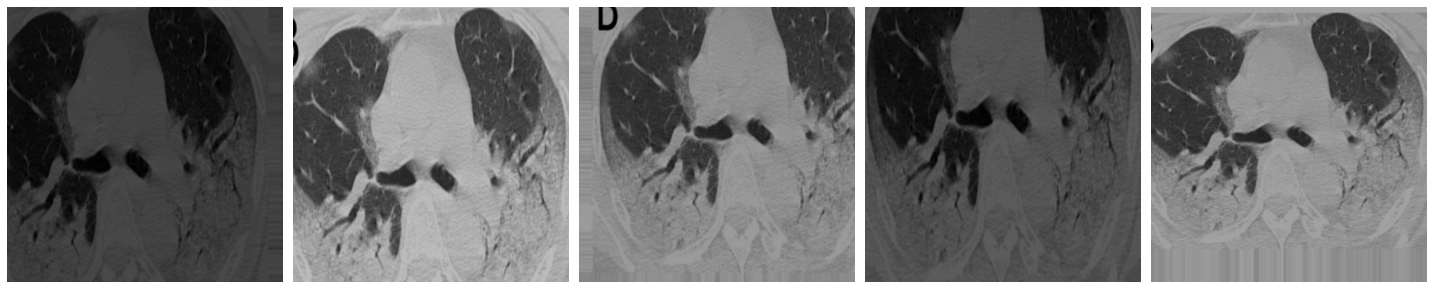

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

augmented_images = [data_train_augmentation[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [25]:
testgen=ImageDataGenerator(rescale=1./255)

data_test=testgen.flow_from_directory(directory=data_test_dir, 
                                      shuffle = False, target_size=IMG_SIZE, class_mode='categorical', batch_size=1)

Found 292 images belonging to 1 classes.


In [10]:
xception_net = Xception(input_shape=(512,512,3), include_top=False, weights="imagenet", pooling="max")
for layer in xception_net.layers:
    layer.trainable = False

model = Sequential()
model.add(xception_net)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(200, kernel_initializer=w_init, bias_initializer=b_init, kernel_regularizer='l2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax', kernel_initializer=w_init, bias_initializer=b_init,  kernel_regularizer='l2'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               409800    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [11]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=False,
    name="Adam",
)


loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.05,
    reduction="auto",
    name="categorical_crossentropy",
)



In [12]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
model.fit(data_train1, epochs=30, verbose=1)

Epoch 1/30
37/37 [==============================] - 69s 2s/step - loss: 2.5069 - accuracy: 0.8479
Epoch 2/30
37/37 [==============================] - 69s 2s/step - loss: 2.4806 - accuracy: 0.8247
Epoch 3/30
37/37 [==============================] - 69s 2s/step - loss: 2.4102 - accuracy: 0.8393
Epoch 4/30
37/37 [==============================] - 69s 2s/step - loss: 2.3750 - accuracy: 0.8411
Epoch 5/30
37/37 [==============================] - 69s 2s/step - loss: 2.3031 - accuracy: 0.8651
Epoch 6/30
37/37 [==============================] - 69s 2s/step - loss: 2.2826 - accuracy: 0.8471
Epoch 7/30
37/37 [==============================] - 69s 2s/step - loss: 2.2604 - accuracy: 0.8393
Epoch 8/30
37/37 [==============================] - 69s 2s/step - loss: 2.1885 - accuracy: 0.8591
Epoch 9/30
37/37 [==============================] - 69s 2s/step - loss: 2.1473 - accuracy: 0.8617
Epoch 10/30
37/37 [==============================] - 69s 2s/step - loss: 2.1237 - accuracy: 0.8522
Epoch 11/30
37/37 [

In [19]:
# model.save("xception_max_9106.h5")


In [ ]:
# model.evaluate(data_validation_no_augmentation, verbose=2)

In [16]:
model.fit(data_train2, epochs=30, validation_data=data_val2, verbose=1,callbacks=[modelcheckpoint])

Epoch 1/30
30/30 [==============================] - 73s 2s/step - loss: 1.4611 - accuracy: 0.8627 - val_loss: 1.3465 - val_accuracy: 0.9397
Epoch 2/30
30/30 [==============================] - 69s 2s/step - loss: 1.4340 - accuracy: 0.8820 - val_loss: 1.3311 - val_accuracy: 0.9353
Epoch 3/30
30/30 [==============================] - 69s 2s/step - loss: 1.4339 - accuracy: 0.8755 - val_loss: 1.3468 - val_accuracy: 0.9095
Epoch 4/30
30/30 [==============================] - 69s 2s/step - loss: 1.3820 - accuracy: 0.8863 - val_loss: 1.3025 - val_accuracy: 0.9310
Epoch 5/30
30/30 [==============================] - 69s 2s/step - loss: 1.3839 - accuracy: 0.8573 - val_loss: 1.2876 - val_accuracy: 0.9138
Epoch 6/30
30/30 [==============================] - 69s 2s/step - loss: 1.3550 - accuracy: 0.8820 - val_loss: 1.2719 - val_accuracy: 0.9095
Epoch 7/30
30/30 [==============================] - 69s 2s/step - loss: 1.3434 - accuracy: 0.8798 - val_loss: 1.2510 - val_accuracy: 0.9353
Epoch 8/30
30/30 [==

In [ ]:
model.optimizer.lr = 0.0001
print(tf.keras.backend.eval(model.optimizer.lr))

1e-04


In [17]:

model.save(output_training +"/xception_max_9138.h5")

In [30]:
val_model = tf.keras.models.load_model(output_training + "/xception_424-954.h5")


In [31]:
predicted_classes = np.argmax(val_model.predict(data_test), axis = -1)

In [32]:
test_id = data_test.filenames
new_test_id = [x.replace('.png', '').replace('test_image/', '') for x in test_id]


In [33]:
evaluation = pd.DataFrame({'ID':new_test_id, 'Label':predicted_classes})
evaluation.to_csv(output_dir + "xception_16_10_2_evaluation_submission.csv", index=False) # Public Score: 0.76555
evaluation.head()

,ID,Label
0,0,0
1,1,1
2,10,0
3,100,2
4,101,1


In [ ]:
model.save(output_dir + "xception_noise_model.h5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_output/check_point/assets


In [18]:
!cp -r 'model_output' '/content/drive/My Drive/ai/xception_max' 

In [ ]:
!rm -r 'model_output'

In [24]:
!cp -r '/content/drive/My Drive/ai/test_image' .

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(output_dir + "xception_noise_model.h5")

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 30)                3932190   
_________________________________________________________________
batch_normalization_4 (Batch (None, 30)                120       
_________________________________________________________________
activation (Activation)      (None, 30)                0

In [ ]:
np.argmax(model.predict(data_test), axis = -1)

array([0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0,
       1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0, 0, 2, 1, 2,
       1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       0, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2,
       1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1,
       1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 1,
       0, 1, 2, 1, 1, 0])

In [ ]:
np.argmax(new_model.predict(data_test), axis = -1)

array([0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0,
       1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 2, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0,
       1, 1, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0, 0, 2, 1, 2,
       1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       0, 1, 1, 2, 2, 0, 2, 0, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 0, 2, 0,
       0, 0, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2,
       1, 0, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 1,
       2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 1,
       1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 1,
       0, 1, 2, 1, 1, 0])

In [ ]:
new_model.fit(data_train_noise, epochs=30, validation_data=data_validation_noise, verbose=1, callbacks=[tensorboard])

Epoch 1/30
 6/30 [=====>........................] - ETA: 50s - loss: 0.5440 - accuracy: 0.9583

KeyboardInterrupt: ignored

In [ ]:
print(tf.keras.backend.eval(model.optimizer.lr))

1e-04


In [ ]:
model.optimizer.lr = 0.01
print(tf.keras.backend.eval(new_model.optimizer.lr))

0.01


In [ ]:
import cv2
import numpy as np
import skimage as sk
from skimage import io 

from skimage.transform import rotate, AffineTransform, warp
import matplotlib.pyplot as plt
import random
from skimage import img_as_ubyte
import os
from skimage.util import random_noise

In [ ]:
def random_rotation(image):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image, random_degree)

def random_noise(image):
    # add random noise to the image
    return sk.util.random_noise(image)

def blurring(iamge):
  return cv2.GaussianBlur(iamge, (9,9),0)

def contrast(image):
    return 2*image

def inverse_color(image):
    return sk.util.invert(image)

def affine_transform(image):
  _tf = AffineTransform(shear=-0.5)
  return warp(image, _tf, order=1, preserve_range=True, mode='wrap')

  
available_transformations = {'rotation': random_rotation, 'noise':random_noise, 'blur':blurring, 'contrast':contrast, 'inverse': inverse_color , 'affine':affine_transform}




(32, 3)

In [ ]:

for i in range(len(filename)):    
  image_to_transform = sk.io.imread(data_train_dir + "/" + filename[i])
  for key, value in available_transformations.items():  
    transformed_image = value(image_to_transform)
    sk.io.imsave( data_augment_dir +"/" + key + "_" + filename[i], transformed_image)
    train_label.append({'ID' : filename[i], 'Label':label[i]}, ignore_index=True)

  # for l in label:
  #   print(f,l)

In [ ]:
images = [os.path.join(data_train_dir, f) for f in os.listdir(data_train_dir) if os.path.isfile(os.path.join(data_train_dir, f))]
num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)


In [ ]:
# dictionary of the transformations functions we defined earlier
available_transformations = [random_noise, random_rotation, blur_image, Zoom, warp_shift, contrast , bright, ]
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

# random num of transformations to apply
num_transformations_to_apply = random.randint(1, len(available_transformations))

num_transformations = 0
transformed_image = None
while num_transformations <= num_transformations_to_apply:
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](image_to_transform)
    num_transformations += 1

In [ ]:

# define a name for our new file
new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

# write image to the disk
sk.io.imsave(new_file_path, transformed_image)